# Spam generation

## Installation & setup

In [ ]:
import torch
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel, GPT2LMHeadModel

## Tokenizer

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
tokenizer_config = {
  'padding': 'max_length',
  'truncation': True,
  'max_length': 128,
  'return_tensors': 'pt'
}

## Dataset

In [ ]:
SPAM_LABEL = 'spam'
NO_SPAM_LABEL = 'not spam'

SPAM_LABEL_2_ID_MAP = {
    NO_SPAM_LABEL: 0,
    SPAM_LABEL: 1
}

SPAM_ID_2_LABEL_MAP = {
    0: NO_SPAM_LABEL,
    1: SPAM_LABEL
}

### Email Spam Classification

https://huggingface.co/datasets/TrainingDataPro/email-spam-classification

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("TrainingDataPro/email-spam-classification")

test_size = 0.2

if 'train' in dataset:
    dataset_split = dataset['train'].train_test_split(test_size=test_size)
else:
    raise ValueError("The dataset does not have a train split.")

train_dataset = dataset_split['train']
test_dataset = dataset_split['test']

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

In [ ]:
def map_function(item):
    return {
        'type': item['type'],
        'text': item['text'],
        'title': item['title'],
        'label': float(SPAM_LABEL_2_ID_MAP[item['type']])
    }

train_dataset = train_dataset.map(map_function)
test_dataset = test_dataset.map(map_function)

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

batch_size = 16

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

### Enron Spam Dataset


https://github.com/MWiechmann/enron_spam_data/

In [ ]:
!gdown 1a4nu8iJmy_RzgjT2NVtKTlCTwOYozcOh

Downloading...
From: https://drive.google.com/uc?id=1a4nu8iJmy_RzgjT2NVtKTlCTwOYozcOh
To: /content/enron_spam_data.zip
100% 15.6M/15.6M [00:00<00:00, 45.7MB/s]


In [ ]:
!unzip /content/enron_spam_data.zip -d /content/

Archive:  /content/enron_spam_data.zip
  inflating: /content/enron_spam_data.csv  


In [ ]:
import pandas as pd

df = pd.read_csv('/content/enron_spam_data.csv')

In [ ]:
df.head()

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14


In [ ]:
df = df.dropna()

In [ ]:
len(df)

33107

In [ ]:
from torch.utils.data import Dataset, DataLoader

batch_size = 16

class CSVDataset(Dataset):
    def __init__(self, csv_file, split='train', test_split_ratio=0.1, max_n_rows=10_000):
        self.data_frame = pd.read_csv(csv_file).dropna()
        self.data_frame = self.data_frame[:min(len(self.data_frame), max_n_rows)]

        n_rows = len(self.data_frame)
        if split == 'train':
          self.data_frame = self.data_frame.iloc[0:int(n_rows * (1 - test_split_ratio))]
        else:
          self.data_frame = self.data_frame.iloc[int(n_rows * (1 - test_split_ratio)):]

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        return {
            'label': 0 if self.data_frame.iloc[idx]['Spam/Ham'] == 'ham' else 1,
            'text': self.data_frame.iloc[idx]['Message'],
            'title': self.data_frame.iloc[idx]['Subject'],
        }

csv_file = '/content/enron_spam_data.csv'

train_dataset = CSVDataset(csv_file)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

test_dataset = CSVDataset(csv_file, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [ ]:
# for i in train_loader:
#   print(i)

## GAN

The GAN model is inspired by TextGail:
- code: https://github.com/qywu/TextGAIL/tree/master,
- article: https://arxiv.org/pdf/2004.13796.

### Generator

In [ ]:
class TextGenerator(nn.Module):
  def __init__(self, max_new_tokens=128):
    super(TextGenerator, self).__init__()

    self.max_new_tokens = max_new_tokens
    self.model = GPT2LMHeadModel.from_pretrained('gpt2')

  def forward(self, inputs):
    return self.model.generate(
        **inputs,
        max_new_tokens=self.max_new_tokens,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id
    )

#### On hold: RNN

Simple text generation model from https://www.kaggle.com/code/ab971631/beginners-guide-to-text-generation-pytorch

Useful links:
- https://github.com/purvasingh96/Deep-learning-with-neural-networks/blob/master/Chapter-wise%20code/Code%20-%20PyTorch/6.%20Natural-Language-Processing/8.%20Natural%20Language%20Generation/text-generation-via-rnn-and-lstms-pytorch.ipynb

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers, batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden=None):
        if hidden is None:  # Initialize hidden state if not provided
            hidden = self.init_hidden()
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

### Discriminator 1 - Spam classifier

In [ ]:
class SpamDiscriminator(nn.Module):
  def __init__(self, num_labels=2):
    super(SpamDiscriminator, self).__init__()

    self.model = RobertaModel.from_pretrained('roberta-base')
    self.classifier = nn.Linear(self.model.config.hidden_size, 1)

  def forward(self, inputs):
    outputs = self.model(**inputs)

    # Use the hidden states of the [CLS] token for classification
    cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token is the first token

    logits = self.classifier(cls_output)
    prob = torch.sigmoid(logits)
    return prob

In [ ]:
input_text = "Congratulations! You've won a $1,000 Walmart gift card."

inputs = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True)

model = SpamDiscriminator()

model.eval()
with torch.no_grad():
    prob = model(inputs).item()

threshold = 0.5
predicted_class = 1 if prob >= threshold else 0

print(f"Probability of spam: {prob:.4f}, predicted class: {SPAM_ID_2_LABEL_MAP[predicted_class]}")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Probability of spam: 0.5143, predicted class: spam


### Discriminator 2 - Detector of generated text

In [ ]:
class AiGeneratedDiscriminator(nn.Module):
  def __init__(self, num_labels=2):
    super(AiGeneratedDiscriminator, self).__init__()

    self.model = RobertaModel.from_pretrained('roberta-base')
    self.classifier = nn.Linear(self.model.config.hidden_size, 1)

  def forward(self, inputs):
    outputs = self.model(**inputs)

    # Use the hidden states of the [CLS] token for classification
    cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token is the first token

    logits = self.classifier(cls_output)
    prob = torch.sigmoid(logits)
    return prob

In [ ]:
input_text = "Congratulations! You've won a $1,000 Walmart gift card."

inputs = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True)

model = SpamDiscriminator()

model.eval()
with torch.no_grad():
    prob = model(inputs).item()

print(f"Probability of the text being generated by AI: {prob:.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Probability of the text being generated by AI: 0.5417


## Save / restore models

In [ ]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 8.8 MB/s eta 0:00:00


In [ ]:
import boto3
import os
from google.colab import userdata

os.environ['AWS_ACCESS_KEY_ID'] = userdata.get('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get('AWS_SECRET_ACCESS_KEY')

BUCKET_NAME = "spam-detection-ensta"

def upload_to_s3(file_path, s3_file_name, bucket_name=BUCKET_NAME):
    s3 = boto3.client("s3")

    try:
        s3.upload_file(file_path, bucket_name, s3_file_name)
        print(f"Successfully uploaded {file_path} to s3://{bucket_name}/{s3_file_name}")
    except Exception as e:
        print(f"Error uploading file: {e}")


def download_from_s3(s3_file_name, local_file_path, bucket_name=BUCKET_NAME):
    s3 = boto3.client("s3")

    try:
        s3.download_file(bucket_name, s3_file_name, local_file_path)
        print(
            f"Successfully downloaded s3://{bucket_name}/{s3_file_name} to {local_file_path}"
        )
    except Exception as e:
        print(f"Error downloading file: {e}")


In [ ]:
def save_weights(model, filepath, save_to_s3=True):
    torch.save(model.state_dict(), filepath)

    if save_to_s3:
        upload_to_s3(filepath, s3_file_name=filepath)

def restore_weights(model, filepath, load_from_s3=True):
    try:
        if load_from_s3:
            download_from_s3(filepath, filepath)
        model.load_state_dict(torch.load(filepath))
        print("\nSuccessfully restored weights")
    except Exception as e:
        print(f"\nError restoring weights: {e}")

## Training setup

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models

generator = TextGenerator().to(device)
discriminator_A = SpamDiscriminator().to(device)
discriminator_B = AiGeneratedDiscriminator().to(device)

# Optimizers

optimizer_G = optim.Adam(generator.parameters(), lr=0.002)
optimizer_D_A = optim.Adam(discriminator_A.parameters(), lr=0.001)
optimizer_D_B = optim.Adam(discriminator_B.parameters(), lr=0.001)

# Loss function

criterion = nn.BCELoss()

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
GENERATOR_FILEPATH = 'generator.pth'
DISCRIMINATOR_A_FILEPATH = 'discriminator_A.pth'
DISCRIMINATOR_B_FILEPATH = 'discriminator_B.pth'

In [ ]:
save_weights(generator, 'generator_copy.pth')
save_weights(discriminator_A, 'discriminator_A_copy.pth')
save_weights(discriminator_B, 'discriminator_B_copy.pth')

Successfully uploaded generator_copy.pth to s3://spam-detection-ensta/generator_copy.pth
Successfully uploaded discriminator_A_copy.pth to s3://spam-detection-ensta/discriminator_A_copy.pth
Successfully uploaded discriminator_B_copy.pth to s3://spam-detection-ensta/discriminator_B_copy.pth


In [ ]:
# save_weights(generator, GENERATOR_FILEPATH)
restore_weights(generator, GENERATOR_FILEPATH)

Successfully uploaded generator.pth to s3://spam-detection-ensta/generator.pth


In [ ]:
# save_weights(discriminator_A, DISCRIMINATOR_A_FILEPATH)
restore_weights(discriminator_A, DISCRIMINATOR_A_FILEPATH)

Successfully uploaded discriminator_A.pth to s3://spam-detection-ensta/discriminator_A.pth
Successfully downloaded s3://spam-detection-ensta/discriminator_A.pth to discriminator_A.pth


<ipython-input-29-1b633ca46c12>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath))



Successfully restored weights


In [ ]:
# save_weights(discriminator_B, DISCRIMINATOR_B_FILEPATH)
restore_weights(discriminator_B, DISCRIMINATOR_B_FILEPATH)

Successfully uploaded discriminator_B.pth to s3://spam-detection-ensta/discriminator_B.pth
Successfully downloaded s3://spam-detection-ensta/discriminator_B.pth to discriminator_B.pth


<ipython-input-29-1b633ca46c12>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath))



Successfully restored weights


## Training loop  

In [ ]:
from tqdm import tqdm

num_epochs = 20

losses = {
    'generator': [],
    'spam_discriminator': [],
    'ai_discriminator': []
}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}...\n")

    for batch in tqdm(train_loader):
        text_tokenized = tokenizer(batch['text'], **tokenizer_config).to(device)
        title_tokenized = tokenizer(batch['title'], **tokenizer_config).to(device)
        labels = batch['label'].float().to(device)

        fake_text = generator(title_tokenized).to(device) # Generate text corpus for given titles

        # Train Discriminator A - Spam detector
        optimizer_D_A.zero_grad()
        output_A_real = discriminator_A(text_tokenized)
        output_A_fake = discriminator_A({'input_ids': fake_text})
        loss_D_A = criterion(output_A_real.view(-1).float().to(device), labels) + \
                    criterion(output_A_fake.view(-1).float().to(device), torch.ones(batch_size).float().to(device))
        loss_D_A.backward()
        optimizer_D_A.step()

        # Train Discriminator B - AI-Generated text detector
        optimizer_D_B.zero_grad()
        output_B_real = discriminator_B(text_tokenized)
        output_B_fake = discriminator_B({'input_ids': fake_text})
        loss_D_B = criterion(output_B_real.view(-1).float().to(device), torch.zeros(batch_size).float().to(device)) + \
                    criterion(output_B_fake.view(-1).float().to(device), torch.ones(batch_size).float().to(device))
        loss_D_B.backward()
        optimizer_D_B.step()

        # Train Generator
        optimizer_G.zero_grad()
        output_A_fake = discriminator_A({'input_ids': fake_text})
        output_B_fake = discriminator_B({'input_ids': fake_text})
        loss_G = criterion(output_A_fake.view(-1).to(device), torch.zeros(batch_size).to(device)) + \
                    criterion(output_B_fake.view(-1).to(device), torch.zeros(batch_size).to(device))
        loss_G.backward()
        optimizer_G.step()

    losses['generator'].append(loss_G.item())
    losses['spam_discriminator'].append(loss_D_A.item())
    losses['ai_discriminator'].append(loss_D_B.item())

    save_weights(generator, GENERATOR_FILEPATH)
    save_weights(discriminator_A, DISCRIMINATOR_A_FILEPATH)
    save_weights(discriminator_B, DISCRIMINATOR_B_FILEPATH)

    print(f'\nEpoch [{epoch + 1}/{num_epochs}], Loss D_A: {loss_D_A.item()}, Loss D_B: {loss_D_B.item()}, Loss G: {loss_G.item()}')


Epoch 1...



100%|██████████| 562/562 [45:19<00:00,  4.84s/it]


Successfully uploaded generator.pth to s3://spam-detection-ensta/generator.pth
Successfully uploaded discriminator_A.pth to s3://spam-detection-ensta/discriminator_A.pth
Successfully uploaded discriminator_B.pth to s3://spam-detection-ensta/discriminator_B.pth

Epoch [1/20], Loss D_A: 0.11036050319671631, Loss D_B: 1.3862944841384888, Loss G: 8.206405639648438

Epoch 2...



100%|██████████| 562/562 [45:16<00:00,  4.83s/it]


Successfully uploaded generator.pth to s3://spam-detection-ensta/generator.pth
Successfully uploaded discriminator_A.pth to s3://spam-detection-ensta/discriminator_A.pth
Successfully uploaded discriminator_B.pth to s3://spam-detection-ensta/discriminator_B.pth

Epoch [2/20], Loss D_A: 0.4839150011539459, Loss D_B: 1.3862944841384888, Loss G: 7.617927551269531

Epoch 3...



100%|██████████| 562/562 [45:12<00:00,  4.83s/it]


Successfully uploaded generator.pth to s3://spam-detection-ensta/generator.pth
Successfully uploaded discriminator_A.pth to s3://spam-detection-ensta/discriminator_A.pth
Successfully uploaded discriminator_B.pth to s3://spam-detection-ensta/discriminator_B.pth

Epoch [3/20], Loss D_A: 0.6370099186897278, Loss D_B: 1.3862943649291992, Loss G: 7.42940092086792

Epoch 4...



 98%|█████████▊| 553/562 [44:30<00:43,  4.79s/it]

In [ ]:
torch.cuda.empty_cache()

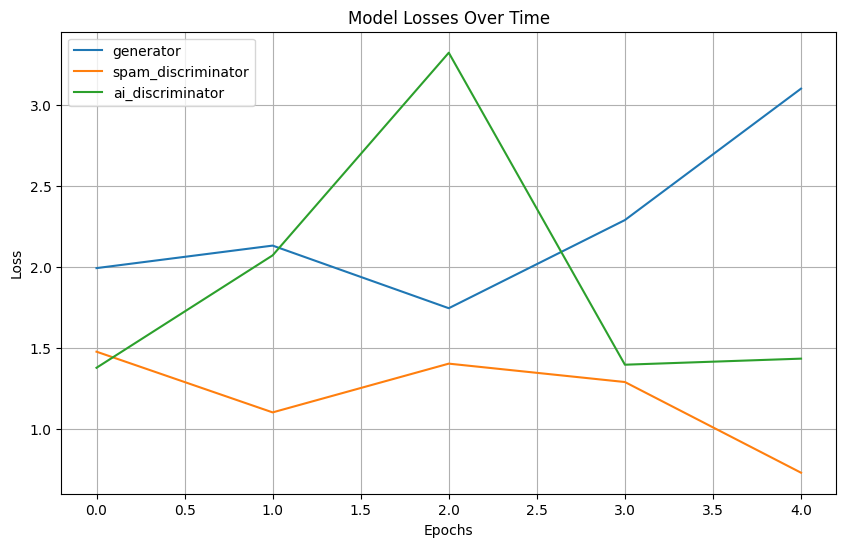

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for key, value in losses.items():
    plt.plot(value, label=key)

plt.title('Model Losses Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
# plt.ylim(0, 1)  # Adjust y-axis limit if necessary

plt.show()

## Test

In [ ]:
example_title = "AFE Model Casting Call"

inputs = tokenizer(example_title, return_tensors='pt', padding=True, truncation=True)

generated = generator(inputs.to(device))

In [ ]:
decoded_output = tokenizer.decode(generated[0], skip_special_tokens=True)

print(decoded_output)

AFE Model Casting Call as love than is out on out on out on Call as love than is out on out on out on Call as love than is out on out on out on Call as love than is out on out on out on Call as love than is out on out on out on Call as love than is out on out on out on Call as love than is out on out on out on Call as love than is out on out on out on Call as love than is out on out on out on Call as love than is out on out on out on Call as love than is out on out on


## TODO

***NB: Please make a copy of this notebook before doing any changes***

**Part 1 - Can be done now in parallel**

- Find larger dataset or find ways to augment the existing dataset

Dataset specification (each item of the dataset should be in the following format):
```
{
        'text': string,
        'title': string
        'label': 0 (not spam) or 1 (spam)
}
```

If you find a dataset not coressponding to this format, please use mapping.

- Find metrics to evaluate the richness and realness of the generated text, preferably we will include this into the loss function of the generator

- Experiment with architectures of generator. This network takes as an input a title of a spam email and generates email body (text). The generator can be also unconditional, e.g. not taking anything as input and just generating random text of a spam email

- Experiment with architectures of the AI generated detector. This network takes as an input a tokenized text and returns a probability [0, 1] that this text is AI generated

- Experiment with architectures of the Spam classifier. This network takes as an input a tokenized text and returns a probability [0, 1] that this text is spam

**Part 2: TODO after Part 1**

- Pre-train Spam classifier

- Pre-train Detector of the generated text

**Part 3: TODO after Part 2**

- Fine-tune GAN training. For example, experiment with different learning rates for discriminators and generator